# Linear Position Scaling Strategy
## Smoother Exposure Adjustment Under Stochastic Returns

This notebook examines a linear position scaling rule, in which exposure is increased incrementally following losses and decreased incrementally following gains.

Unlike exponential scaling rules, exposure adjustments occur linearly, leading to smoother capital trajectories and reduced variance. We analyse the behaviour of this strategy using both a single-path simulation and a Monte Carlo experiment, focusing on drawdown behaviour, variance reduction, and residual ruin risk.

### Key Characteristics
- Exposure increases and decreases linearly rather than exponentially
- Loss recovery is gradual rather than aggressive
- Variance is reduced relative to exponential scaling
- Negative expected value remains unchanged

The implementation used here corresponds to the project’s linear scaling rule (internally implemented in the dalembert module).


In [1]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(".."))
sys.path.insert(0, os.path.abspath("../src"))

from ..rng import roulette_like_trial
from ..strategies.dalembert import dalembert_bettor
from ..runner import run_simulation

plt.style.use("seaborn-v0_8-darkgrid")
random.seed(42)

## 1. Simulation Parameters

The following parameters are used for both the single-path and Monte Carlo simulations. Linear scaling moderates exposure growth, but prolonged negative drift can still accumulate risk over time.

In [2]:
initial_funds = 10_000
stake = 100
n_rounds = 100
p_win = 0.49

## 2. Single-Path Capital Evolution

We first simulate a single realisation of the capital process under linear position scaling.

While a single path is not representative of expected performance, it highlights:

- gradual exposure adjustment
- smoother drawdown formation
- residual vulnerability to extended adverse sequences


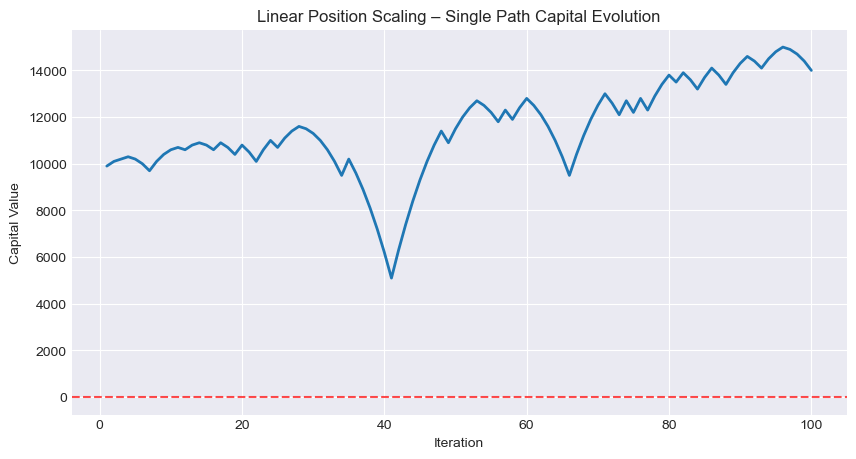

In [3]:
random.seed(42)

def trial():
    return roulette_like_trial(p_win)

wagers, values = dalembert_bettor(
    initial_funds=initial_funds,
    initial_stake=stake,
    n_rounds=n_rounds,
    rng_fn=trial
)

plt.figure(figsize=(10,5))
plt.plot(wagers, values, linewidth=2)
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Capital Value")
plt.title("Linear Position Scaling – Single Path Capital Evolution")
plt.show()

- Exposure adjusts smoothly, limiting extreme drawdowns.
- Loss sequences increase risk more slowly than under exponential scaling.
- Extended periods of negative drift can still lead to capital depletion.


## 3. Monte Carlo Simulation Across Many Paths

We perform a Monte Carlo experiment across many independent paths to characterise the distribution of outcomes and estimate ruin probability under linear position scaling.


In [4]:
n_bettors = 500

final_values, broke_count = run_simulation(
    dalembert_bettor,
    initial_funds,
    stake,
    n_rounds,
    n_bettors,
    p_win=p_win,
    seed=42
)

print("Paths resulting in capital depletion:", broke_count)
print("Ruin probability:", round(broke_count / n_bettors * 100, 2), "%")

mean_value = np.mean(final_values)
median_value = np.median(final_values)

print("Mean final capital:", round(mean_value, 2))
print("Median final capital:", round(median_value, 2))

Paths resulting in capital depletion: 123
Ruin probability: 24.6 %
Mean final capital: 9173.0
Median final capital: 11400.0


## 4. Distribution of Final Capital

The histogram below shows the distribution of final capital values across Monte Carlo paths, illustrating reduced variance relative to exponential scaling alongside persistent tail risk.


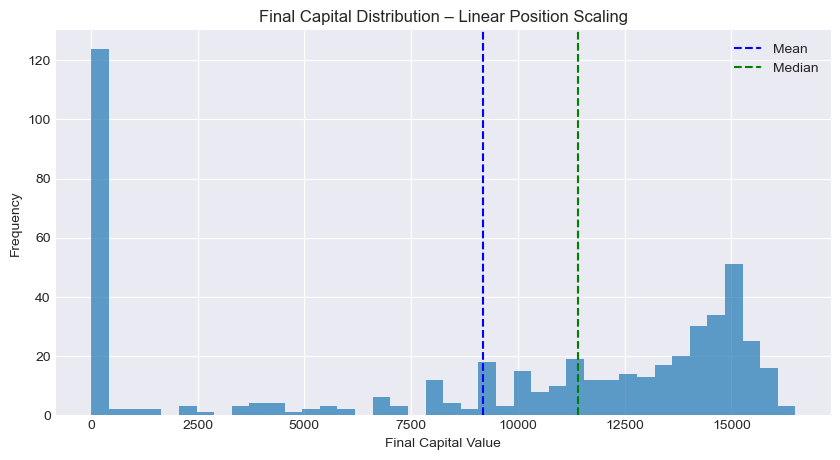

In [5]:
plt.figure(figsize=(10,5))
plt.hist(final_values, bins=40, alpha=0.7)
plt.axvline(mean_value, color="blue", linestyle="--", label="Mean")
plt.axvline(median_value, color="green", linestyle="--", label="Median")
plt.title("Final Capital Distribution – Linear Position Scaling")
plt.xlabel("Final Capital Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Summary

- Linear position scaling moderates exposure growth and reduces variance relative to exponential scaling.
- Capital trajectories are smoother, but tail risk is not eliminated.
- Prolonged negative drift can still result in capital depletion.
- Expected value remains negative despite improved short-horizon behaviour.

This strategy represents a compromise between constant position sizing and aggressive exposure scaling, offering reduced volatility at the cost of slower recovery from losses.
